# Exploring SVM Kernels

This is a short notebook which explores the idea of a kernel function, and how using it can enable separability of classes for a classifier algorithm. Since SVMs essentially use this kernel trick to find the function, and since they can be formulated as a dual convex hull problem, we describe and calculate convex hulls for a simple pair of classes in our data set.

The data used in the notebook are all synthetic and generated within the notebook. We use both Plotly and matplotlib for visualizing kernels. 

***Note**: One of the Python functions for visualization is credited to Jake Van Der Plas' fantastic online book on machine learning.*

In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull

In [38]:
size = 250

In [39]:
x1 = np.random.normal(scale = 1.0, size = size)
x2 = np.random.normal(scale = 1.0, size = size)

df = pd.DataFrame({"x1":x1, "x2":x2})

px.scatter(df, x = "x1", y = "x2")

In [40]:
set1 = []
set2 = []

for item in list(zip(x1,x2)):
    #print(item)
    if np.sqrt(item[0]**2 + item[1]**2) < 1.5:
        set2.append([item[0], item[1]])
    elif 1.5 < np.sqrt(item[0]**2 + item[1]**2) < 100:
        set1.append([item[0]*1.4, item[1]*1.4])

set1, set2 = np.array(set1), np.array(set2)
set1, set2 = np.c_[set1, np.zeros(set1.shape[0])], np.c_[set2, np.ones(set2.shape[0])]
dataset = pd.DataFrame(np.vstack([set1,set2]), columns = ["x1", "x2", "labels"])

In [41]:
px.scatter(dataset, x = "x1", y = "x2", color = "labels", title = "Plotting x1 vs x2 - nonlinearly separable classes")

Setting up convex hulls on both above sets of data can give us an intuition about how these hulls are not separable. If they were separable, the minimum distance between them could be bisected, giving us a decision function for classification. Ultimately, this is what an SVM aims to do.

In [42]:
class1 = dataset[dataset['labels']==1][['x1','x2']].values
hull1 = ConvexHull(class1)
class2 = dataset[dataset['labels']==0][['x1','x2']].values
hull2 = ConvexHull(class2)

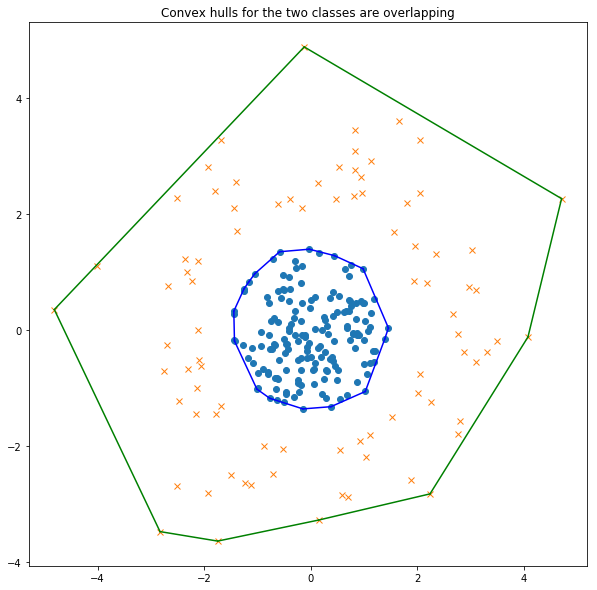

In [43]:
plt.figure(figsize = (10,10))
plt.title ("Convex hulls for the two classes are overlapping")
plt.plot(class1[:,0], class1[:,1], 'o')
for item in hull1.simplices:
    plt.plot(class1[item, 0], class1[item, 1], 'b-')

plt.plot(class2[:,0], class2[:,1], 'x')
for item in hull2.simplices:
    plt.plot(class2[item, 0], class2[item, 1], 'g-')
    
plt.show()

Setting up the kernel based on the mapping $ \phi(x) = (x_{1}^2, x_{1}x_{2}, x_{2}^2)^{T} $

In [44]:
def kernelize (dataset):
    '''
    Transforms a pandas dataframe with columns [x1, x2, labels], to a df with [x1^2, x2^2, x1x2, labels] columns
    '''
    k_df = dataset.copy()
    k_df["x1^2"] = k_df["x1"].apply(lambda x : x**2)
    k_df["x2^2"] = k_df["x2"].apply(lambda x : x**2)
    k_df["x1x2"] = k_df["x1"]*k_df["x2"]
    k_df.drop(['x1', 'x2'], axis = 1)
    
    return k_df

In [45]:
kdf = kernelize(dataset=dataset)

In [46]:
fig = px.scatter_3d(kdf, x="x1^2", y="x2^2", z='x1x2',
              color='labels', opacity = 0.7, symbol = "labels",
                   title = "Visualization with kernel ϕ(x)=( x1^2, x1x2, x2^2 )^T")
fig.show()

## Visualization with a radial basis function kernel

1. The "norm" function within numpy's linear algebra enables us to compute the Euclidean distance
2. The norm is then used as part of the RBF function to calculate the Radial Basis Function, which in this case is a kernel
3. It has been proven that 

In [47]:
rbf = np.exp(-(np.linalg.norm(dataset[['x1','x2']], axis = 1) ** 2))

In [48]:
kdf_rbf = kdf.copy()
kdf_rbf['rbf'] = rbf

kdf_rbf = kdf_rbf.drop(['x1^2', 'x2^2', 'x1x2'], axis = 1)

In [56]:
px.scatter_3d(kdf_rbf, x="x1", y = "x2", z = 'rbf', color = 'labels', 
              size_max = 1, opacity = 0.3, title = "Visualizing data with RBF kernel feature expansion")

In [50]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

In [51]:
X, y = dataset[['x1','x2']], dataset['labels']

xtr, xts, ytr, yts = train_test_split(X, y, test_size = 0.3)

In [52]:
classifier = SVC(C = 10.0, kernel = 'rbf')

classifier.fit(xtr, ytr)

classifier.score(xtr, ytr)

1.0

In [53]:
def plot_svc_decision_function(model, ax=None, plot_support=True):
    """
    Plot the decision function for a 2D SVC
    
    Function authored by Jake van der Plas at https://jakevdp.github.io/PythonDataScienceHandbook/05.07-support-vector-machines.html 
    
    """
    if ax is None:
        ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # create grid to evaluate model
    x = np.linspace(xlim[0], xlim[1], 30)
    y = np.linspace(ylim[0], ylim[1], 30)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape)
    
    # plot decision boundary and margins
    ax.contour(X, Y, P, colors='k',
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])
    
    # plot support vectors
    if plot_support:
        ax.scatter(model.support_vectors_[:, 0],
                   model.support_vectors_[:, 1],
                   s=300, linewidth=1, facecolors='none');
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

## Alternative visualizations using Matplotlib, without Plotly:

In [54]:
from mpl_toolkits import mplot3d
from ipywidgets import interact, fixed

def plot_3D(elev=30, azim=30, X=X, y=y):
    ax = plt.subplot(projection='3d')
    ax.scatter3D(kdf_rbf['x1'], kdf_rbf['x2'], kdf_rbf['rbf'], c=kdf_rbf['labels'], s=100, cmap='autumn')
    ax.view_init(elev=elev, azim=azim)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('r')

interact(plot_3D, elev=(0,45), azip=(0,45),
         X=fixed(X), y=fixed(y));

interactive(children=(IntSlider(value=30, description='elev', max=45), IntSlider(value=30, description='azim',…

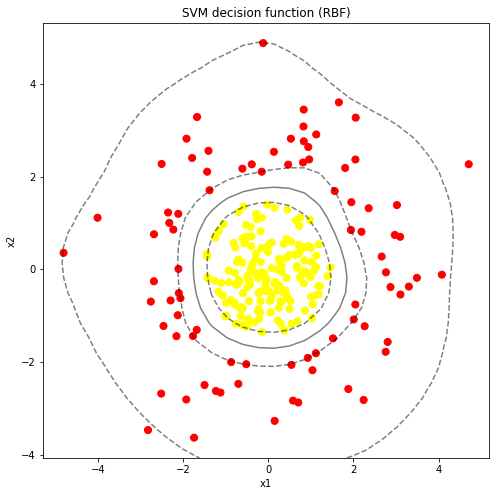

In [55]:
plt.figure(figsize = (8,8))
plt.title("SVM decision function (RBF)")
plt.xlabel("x1")
plt.ylabel("x2")
plt.scatter(X['x1'], X['x2'], c=y, s=50, cmap='autumn')
plot_svc_decision_function(classifier)
plt.scatter(classifier.support_vectors_[:, 0], classifier.support_vectors_[:, 1], s=300, lw=1, facecolors='none');